# **Processamento Digital de Imagens - INF 394**
## **Trabalho Prático Final**
### **Valor:** 40 pontos
### **Entrega:** até dia 16/07/2023 (domingo) 23:59h

---

**Avisos**:

1. Não se assuste com o tamanho do Notebook. Os enunciados primam por tentar esclarecer o que está sendo pedido e ilustrar o máximo possível, quando são dados exemplos. Tudo com objetivo de prevenir dúvidas de sua parte. Em vários casos, o enunciado será muito maior que o código da solução pedida... 😜

1. O trabalho é factível de ser feito sem pesar muito a carga do(a) estudante, se for utilizado o prazo dado (aprox. 3 semanas e meia). No entanto, se deixar para ser feito na última semana ou últimos dias do prazo, aí sim o trabalho pode ficar grande demais. Não deixe pra última hora.

---

# **1. Instruções gerais**

O roteiro do trabalho é o próprio notebook. Siga as instruções das células de texto e faça seus códigos nas células Python.

## **Algumas considerações iniciais:**

- Faça a entrega via Moodle, na atividade correspondente. Lembre-se de antes limpar as saídas em tela, como costumamos fazer nas aulas práticas

- Entregue **apenas** o arquivo `.ipynb` resultante. Não há necessidade de entregar as imagens produzidas

- Copie todo o conteúdo da pasta do link do Drive

- Você é livre para usar tanto o Google Colab quanto uma máquina Jupyter local para desenvolver a atividade

- Lembre-se de salvar o notebook de tempos em tempos

- O trabalho deve ser feito **individualmente**

- O trabalho é composto por várias tarefas individuais, que não são necessariamente conectadas umas às outras. Cada tarefa tem seu próprio enunciado.

- Recomenda-se fazer os exercícios na ordem que se encontram, pois embora as tarefas não estejam necessariamente conectadas umas às outras, em alguns casos estarão. Quando isso acontecer, estará explícito no enunciado.

- Está **vetado** o uso de bibliotecas e implementações prontas dos recursos pedidos nas tarefas deste trabalho. Você deve implementar o recurso pedido.

    - Exemplo 1: se pedido, como alvo da tarefa, que você implemente/faça a conversão de cinza de uma imagem, você não pode usar a conversão que vem pronta na biblioteca PIL

    - Exemplo 2: se um passo secundário de um algoritmo maior demanda a conversão em cinza de uma imagem, mas não é o foco do exercício, você pode usar a conversão pronta da biblioteca PIL

- Está **liberado** o uso de outras bibliotecas que desejar incluir, em especial, as não diretamente relacionadas ao conteúdo de PDI.

- Caso venha a utilizar alguma solução diferente das vistas em aula e/ou fornecidas no material do professor, coloque a fonte (livro, site etc.) de onde foi tirada sua solução.

## **Sobre a avaliação**

- Você receberá, após a correção, uma nota em $100$ (cem) pontos, mas o trabalho vale, efetivamente, $40$. A sua nota "de verdade" será proporcional ao que conseguir aqui. Exemplo: se você tirou $75$ pontos na correção, sua nota será $75 / 100 \cdot 40 = 30$ pontos.

- Um exercício pode ser mais difícil de se bolar a solução mas, ao mesmo tempo, menos trabalhoso pra fazer código que outro, e vice-versa

- Seja estratégico(a) na hora de selecionar o que fazer primeiro

Boa atividade! 😉

# **2. Preâmbulo**

## **Importações das bibliotecas e definição do *path***



Estas são as bibliotecas necessárias pra resolver o trabalho. Mas você é livre para acrescentar quais outras desejar.

In [ ]:
import ipywidgets as widgets
from IPython.display import Markdown
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage import color
import os
import math
from scipy.interpolate import griddata
from scipy.ndimage import generic_filter
from skimage.segmentation import slic
import scipy.stats as sts
from scipy.interpolate import RectBivariateSpline
import scipy.signal as signal
import cv2

- Altere o *path* do código abaixo para a sua pasta de trabalho antes de executar a célula

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
os.chdir('/content/drive/MyDrive/Praticas PDI/Trabalho Final')

## **Informar dados pessoais**

Preencha os dados, na visualização de formulário à direita, e execute a célula a seguir (nessa ordem). A sua matrícula deve ser sem o prefixo "ES", isto é, deve conter somente os números.

In [ ]:
#@title
def saudacao(evento):
  with output:
    md = Markdown("#### **Olá %s (%d)!**" % (nome.value, matricula.value))
    display(md)

nome = widgets.Text(
    value='',
    placeholder='Informe seu nome completo',
    description='Nome:',
    disabled=False
)

display(nome)

matricula = widgets.IntText(
    value = 0,
    description='Matrícula',
    disabled=False
)

display(matricula)

botao = widgets.Button(
    description='Enviar',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Clique'
)
botao.on_click(saudacao)

display(botao)

output = widgets.Output()
display(output)

## **Funções auxiliares prontas**

Algumas funcionalidades já se encontram implementadas pra você. Você é incentivado(a) a utilizar estas funções. Estas funções já são conhecidas das aulas práticas, portanto, dispensaremos comentários a respeito de cada uma. Em caso de dúvidas, consulte os notebooks das aulas (teóricas e práticas).

Execute cada uma das células contendo as declarações de função.

In [ ]:
def gera_imagem(arr):
  arrImg = arr.round().clip(0,255).astype(np.uint8)
  return Image.fromarray(arrImg)

In [ ]:
def exibe_mosaico(imagens, legendas, colunas=4, arquivo=None):
  # Largura e altura básicos, de referência, das imagens
  l = 4
  a = 3

  n_imagens = len(imagens)
  if len(imagens) < colunas:
    colunas = len(imagens)
  linhas = n_imagens // colunas + int(n_imagens % colunas > 0)

  fig = plt.figure(figsize=(l*colunas,a*linhas))
  ax = []

  i = j = 0
  for pos, img in enumerate(imagens):
    i = pos // colunas
    j = pos % colunas
    ax.append(fig.add_subplot(linhas, colunas, pos+1))
    ax[-1].axis('off')
    if img.mode == 'L' or img.mode == '1':
      img = img.convert('RGB')
    arr = np.asarray(img)
    ax[-1].imshow(arr)
    ax[-1].set_title(legendas[pos])

  fig.tight_layout()

  if arquivo is not None:
    plt.savefig(arquivo, dpi=300)

  plt.show()

In [ ]:
def rmse(obj1, obj2):
  if not isinstance(obj1, np.ndarray):
    arr1 = np.asarray(obj1).copy()
  else:
    arr1 = obj1

  if not isinstance(obj2, np.ndarray):
    arr2 = np.asarray(obj2).copy()
  else:
    arr2 = obj2

  return np.sqrt(np.mean((arr1 - arr2)**2))

In [ ]:
def Log2(x):
  if x == 0:
    return False

  return math.log10(x) / math.log10(2)

def potencia2(n):
  return math.ceil(Log2(n)) == math.floor(Log2(n))

# **3. Tarefas**

Cada tarefa, a seguir, possui um título que a identifica e estão delimitadas por uma barra horizontal, como esta que está imediatamente abaixo deste parágrafo.

---

# **Ajudando astrônomos**

A agência espacial BRASA necessitava de fotografar uma região do globo terrestre usando um de seus satélites. No entanto, chegou a notícia de que, no momento programado para que a aquisição da imagem fosse feita, iria ocorrer uma tempestade solar. Sabidamente, esta tempestade causaria muita interferência na transmissão dos dados da foto para a base na Terra.

Sabendo deste fato, a agência te contratou para auxiliá-los a amenizar o problema. Como precaução, fizeram a aquisição de 100 fotos, com intervalos ínfimos de tempo entre cada uma delas, de forma que os objetos das imagens ficassem todos nas mesmas posições, variando apenas o ruído imposto pela interferência.

A você foi delegada a tarefa de realizar a reconstrução de uma foto "limpa", sem ruídos, a partir de um conjunto de fotos repletas destes defeitos.

As fotos ruidosas que lhe foram fornecidas encontram-se na pasta `imagens/ruidos/`. *(Cada uma delas é, na verdade, uma versão de uma foto original com ruído sal-pimenta adicionado aleatoriamente sobre uma parcela dos pixels da mesma.)*

Os arquivos estão nomeados com `sateliteDDD.png`, onde `DDD` é um valor entre `001` e `100`. Na pasta `imagens/` encontra-se o arquivo `satelite.png`, que é a imagem original que foi usada como base para simular o cenário descrito neste enunciado.

Numa situação realista, não existe tal foto original, mas, uma vez que no nosso caso simulado nós temos, vamos utilizá-la para avaliar a qualidade da recontrução.

Pede-se, então, que se implemente os seguintes passos na célula abaixo:

- Abra a imagem original

- Crie uma lista vazia chamada `qtd` e outr chamada `erros`

- Para tamanhos de $n$ de 2 a 100, faça:

  - Reconstrua uma imagem com menor intensidade de ruído a parttir dos arrays das $n$ primeiras imagens ruidosas (use a ordem dada pela nomenclatura dos arquivos descrita acima). Utilize como reconstrução a **média**.

  - Ajuste os dados da matriz reconstruída, isto é, realize arredondamento e truncamento dos valores para que fiquem dentro das restrições do RGB. Atente-se aos tipos de dados...

    - **Obs.:** Chame a matriz de reconstrução de `reconst`, pois este nome de variável será utilizado na hora de visualizar o resultado final (na parte já pronta do código).

  - Calcule o erro cometido pela aproximação, isto é, compare a reconstrução obtida na iteração com a imagem original, "limpa". Use a função `rmse`, que já veio pronta para você. Esta função aceita como entradas duas imagens, dois arrays ou uma imagem e um array (se for este último caso, em qualquer ordem).

  - Adicione o valor de $n$ à lista `qtd` e o valor do erro na lista `erros`

- Em seguida, é feita a exibição dos resultados, cujo código já se encontra pronto e utiliza as variáveis `qtd`, `erros` e `reconst`.

In [ ]:
################################ INÍCIO DO SEU CÓDIGO ##################
def constroi_imagem(path):
  return np.array(Image.open(os.path.join('imagens/ruidos', path)))


arquivos = sorted(os.listdir('imagens/ruidos'))
original = Image.open('imagens/satelite.png')

qtd = []
erros = []

for i in range(2, 100):
  imagens = []

  imagens.extend([constroi_imagem(arq) for arq in arquivos[0:i]])
  reconst = np.mean(imagens, axis=0).astype(float)
  reconst = np.clip(reconst, 0, 255)

  qtd.append(i)
  erros.append(rmse(original, reconst))


################################ TÉRMINO DO SEU CÓDIGO ##################

plt.plot(qtd, erros)
plt.xlabel('Número de imagens')
plt.ylabel('Erro de aproximação')
plt.grid()
plt.title('Remoção de ruído usando diversas amostras de imagens')
plt.show()

imgReconst = gera_imagem(reconst)

print('RMSE: %.3f' % rmse(original, imgReconst))

exibe_mosaico([original, imgReconst], ['Original', 'Reconstruída com 100 amostras'])

#### **Responda às perguntas a seguir**

a) Com base no aspecto visual apenas, o que você tem a dizer da qualidade da reconstrução com 100 imagens? (execute a célula a seguir para responder)

In [267]:
#@title
def aceitacao(e):
  with output:
    md = Markdown('#### **Resposta salva.**')
    display(md)

txt = Markdown('#### **Atenção:** Execute esta célula clicando no botãozinho de "play", antes de preencher e salvar sua resposta!')
rotulo = widgets.Label(display(txt))
display(rotulo)

resposta = widgets.Textarea(
    value='',
    placeholder='Escreva aqui sua resposta',
    description='Resposta:',
    rows=5,
    layout=widgets.Layout(width='800px')
)
display(resposta)

output = widgets.Output()
display(output)

botao = widgets.Button(
    description='Salvar resposta'
)
botao.on_click(aceitacao)

display(botao)

#### **Atenção:** Execute esta célula clicando no botãozinho de "play", antes de preencher e salvar sua resposta!

Label(value='')

Textarea(value='', description='Resposta:', layout=Layout(width='800px'), placeholder='Escreva aqui sua respos…

Output()

Button(description='Salvar resposta', style=ButtonStyle())

b) Com base no gráfico plotado, o que você conclui em relação à qualidade da reconstrução *versus* o número de imagens utilizadas? (execute a célula a seguir para responder)

In [268]:
#@title
def aceitacao(e):
  with output:
    md = Markdown('#### **Resposta salva.**')
    display(md)

txt = Markdown('#### **Atenção:** Execute esta célula clicando no botãozinho de "play", antes de preencher e salvar sua resposta!')
rotulo = widgets.Label(display(txt))
display(rotulo)

resposta = widgets.Textarea(
    value='',
    placeholder='Escreva aqui sua resposta',
    description='Resposta:',
    rows=5,
    layout=widgets.Layout(width='800px')
)
display(resposta)

output = widgets.Output()
display(output)

botao = widgets.Button(
    description='Salvar resposta'
)
botao.on_click(aceitacao)

display(botao)

#### **Atenção:** Execute esta célula clicando no botãozinho de "play", antes de preencher e salvar sua resposta!

Label(value='')

Textarea(value='', description='Resposta:', layout=Layout(width='800px'), placeholder='Escreva aqui sua respos…

Output()

Button(description='Salvar resposta', style=ButtonStyle())

c) O que você acredita que aconteceria se o número de amostras continuasse crescendo para além de 100?  (execute a célula a seguir para responder)

In [265]:
#@title
def aceitacao(e):
  with output:
    md = Markdown('#### **Resposta salva.**')
    display(md)

txt = Markdown('#### **Atenção:** Execute esta célula clicando no botãozinho de "play", antes de preencher e salvar sua resposta!')
rotulo = widgets.Label(display(txt))
display(rotulo)

resposta = widgets.Textarea(
    value='',
    placeholder='Escreva aqui sua resposta',
    description='Resposta:',
    rows=5,
    layout=widgets.Layout(width='800px')
)
display(resposta)

output = widgets.Output()
display(output)

botao = widgets.Button(
    description='Salvar resposta'
)
botao.on_click(aceitacao)

display(botao)

#### **Atenção:** Execute esta célula clicando no botãozinho de "play", antes de preencher e salvar sua resposta!

Label(value='')

Textarea(value='', description='Resposta:', layout=Layout(width='800px'), placeholder='Escreva aqui sua respos…

Output()

Button(description='Salvar resposta', style=ButtonStyle())

- No entanto, é possível se produzir uma solução muito melhor e menos custosa para o problema, que gera um gráfico como o a seguir:

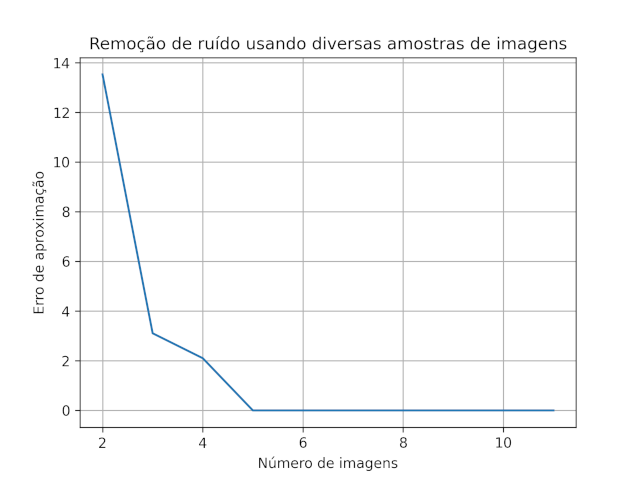

In [ ]:
################################ INÍCIO DO SEU CÓDIGO ##################
def coleta_pixels_ruidozos(img, pixels_ruidozos):
  h, w, _ = img.shape
  for i in range(h):
    for j in range(w):
      if (img[i, j] == 0).all() or (img[i, j] == 255).all():
        pixels_ruidozos.append((i, j))


def remove_ruido(caminho_imagens, passos=100):
  arquivos = sorted(os.listdir(caminho_imagens))
  pixels_ruidozos = []

  reconst = None
  for i, arq in enumerate(arquivos):
    if i == passos: break
    aux = np.asarray(Image.open(os.path.join(caminho_imagens, arq)))
    if not i:
      reconst = aux
      coleta_pixels_ruidozos(reconst, pixels_ruidozos)
      continue

    for x, y in pixels_ruidozos:
      if (aux[x, y]!=0).all() and (aux[x, y]!=255).all():
        reconst[x, y] = aux[x, y]

  return reconst


reconst = remove_ruido('imagens/ruidos',5)
################################ TÉRMINO DO SEU CÓDIGO ##################

imgReconst = gera_imagem(reconst)

print('RMSE: %.3f' % rmse(original, imgReconst))

exibe_mosaico([original, imgReconst], ['Original', 'Reconstruída com 5 amostras'])

---

# **Vamos economizar tinta**

Uma gráfica entrou em contato com você pedindo que a ajudasse a produzir material didático e cultural a custos menores, para que ficassem mais acessíveis. Uma das estratégias adotadas, e onde você entra nessa história, foi quantizar as imagens ilustrativas presentes nos materiais, diminuindo, assim as paletas de cores das imagens.

Conforme visto em sala, a quantização consiste em fazer uma discretização dos tons que vamos utilizar para representar as possíveis cores presentes em uma imagem. Em outras palavras, isto equivale a determinar uma paleta de cores para uma dada imagem.

Dois caminhos possíveis para se fazer uma quantização, de forma que se reduza a paleta de cores de uma certa imagem, são reduzir a quantidades absoluta de cores a serem utilizadas ou reduzir a quantidade de níveis de intensidade em cada canal.

Por exemplo: a partir de uma imagem RGB (~$16$ milhões de cores = $256 \times 256 \times 256$), queremos fazer uma redução de paleta de cores.

Podemos estabelecer, em uma primeira abordagem, a quantidade de níveis por canal para $8$, de onde teremos $8 \times 8 \times 8 = 512$ cores possíveis na nova paleta.

Em uma segunda abordagem podemos obter uma paleta de cores com um total de matizes pré estabelecida com, digamos, $64$ cores, isto é, queremos que a paleta resultante tenha $64$ possibilidades de cor.

Como proposta de solução à gráfica, você irá oferecer soluções que usam as duas abordagens.

### **Abordagem 1: Quantização de níveis de intensidade**

Nesta primeira abordagem, vamos reduzir a quantidade de níveis por canal. A ideia é bastante simples:

1. Estabelece-se uma nova quantidade $qtd$ de níveis

1. Determina-se um fator de ajuste como sendo $f = \frac{255}{qtd - 1}$

1. Para cada nível presente em cada canal da imagem, calcula-se o novo nível como sendo: $novo = arred(\frac{nível}{f + 0,5}) \cdot f$, onde $arred$ é uma função de arredondamento de valores.

Na célula a seguir, complete o código da função `quantizaNiveis` para que implemente o método descrito acima. A função deve ter:

- Parâmetros:

  - `img`: imagem RGB ou monocromática de entrada

  - `qtd`: nova quantidade de níveis por canal

- Retorno:

  - Objeto `PIL Image`, com as cores quantizadas

In [ ]:
def quantizaNiveis(img, qtd):
  ################################ COMPLETE COM SEU CÓDIGO ##################
  img_cpy = np.asarray(img)
  fator = 255/(qtd-1)

  nova_img = np.round((img_cpy / (fator + .5))) * fator

  return gera_imagem(nova_img)


#### **Teste sua solução**

Execute a célula abaixo, para testar sua implementação.

In [ ]:
img = Image.open('imagens/jardim.png')

niveis = [16, 8, 4]
imgs = [img]
legs = ['Original: 256 níveis (~16mi de cores)']

for nivel in niveis:
  imgQuant = quantizaNiveis(img, nivel)
  imgs.append(imgQuant)
  possib = nivel**3
  legs.append('Quantizada com %d níveis (%d cores possíveis)' % (nivel, possib))

exibe_mosaico(imgs, legs, colunas=2)

### **Abordagem 2: Quantização por quantidade de cores**

Embora seja mais intuitiva de se pensar, a implementação por quantidade de cores não é tão direta quanto a abordagem anterior e existem muitos diferentes métodos para fazê-la.

Veremos, neste exercício, um deles, que se chama *median cut*, cuja ideia central é subdividir a imagem em regiões sucessivamente, usando a mediana do canal com maior variação de valores como ponto de corte.

Assim, partimos de uma imagem completa, mapeamos seus pixels em duas regiões, depois cada região é particionada em duas regiões novamente e assim por diante, até encontrarmos uma quantidade de regiões igual ao número de cores para a qual desejamos quantizar a imagem.

Na implementação, temos de ter cautela para evitar produzir regiões vazias, não subdividindo regiões com poucos pixels presentes. Além disso, é conveniente utilizar um "mapa", uma estrutura de dados indicando qual o id da região que cada pixel pertence.

Algoritmo do *median-cut* apresenta um elemento recursivo e encontra-se descrito por meio das 3 funções a seguir:

**Função** `divide_regiao(id, id', q)`:

**Sejam:**
- $R$ a região da imagem identificada por $id$
- $id'$ o id da nova região a ser criada a partir de $R$
- $q$ a quantidade mínima de pixels por região

**Passos:**

**Se** $\mathrm{tamanho}(R) \geq q$ **então**:

  1. Identifica o canal $c$, que apresenta a maior variação de valores naquela região da imagem

  1. Calcula a mediana $m$, dos valores de $c$

  1. $R' \leftarrow \{p \in R | \mathrm{valor}(p) > m\}$

  1. **Se** $R' = \emptyset$:
      - **retorna** *Falso*

  1. **Para** $p \in R$, onde $\mathrm{valor}(p) > m$:
    
    - $\mathrm{valor}(p) \leftarrow id'$

  - **retorna** *Verdadeiro*

**Senão**:
  - **retorna** *Falso*


**Função** `percurso(o, n, t, q)`:

**Sejam:**
- $o$ a lista de percurso em largura
- $n$ o nível de profundidade de subdivisão das regiões
- $t$ a quantidade de tons (cores) que se desejam atingir
- $q$ a quantidade mínima de pixels por região

**Passos:**

1. $n \leftarrow n + 1$

1. **Se** $\mathrm{tamanho}(o[n-1]) \leq t$ **então**
  1. Adiciona lista vazia ao final de $o$

  1. **Para cada** $v \in o[n-1]$ **faça**

    1. Adiciona $v$ ao final de $o[n]$

    1. **Se** $\mathrm{tamanho}(o[n]) = t$ **então encerra laço**

    1. $w \leftarrow v + 2^{n-1}$

    1. **Se** `divide_regiao(v, w, q)` **então**

        1. Adiciona $w$ ao final de $o[n]$

        1. **Se** $\mathrm{tamanho}(o[n]) = t$ **então encerra laço**

  1. **Se** $\mathrm{tamanho}(o[n]) < t$ **então**

    1. `percurso(o, n, t, q)`

**Função** `median_cut(im, t, q, f)`:

**Sejam:**
- $im$ a imagem de entrada
- $t$ a quantidade de tons (cores) que se desejam atingir
- $q$ a quantidade mínima de pixels por região
- $f$ a função que agrega cores de uma mesma região

**Passos:**

1. $o \leftarrow \mathrm{lista}(\mathrm{lista}(0))$

1. $n \leftarrow 0$

1. `percurso(o, n, t, q)`

1. $u \leftarrow $ *sublista da última posição de* $o$

1. **Para cada** $i \in u$ **faça**

  1. $R \leftarrow $ *pixels da imagem com* $id = i$

  1. $C \leftarrow f(R)$

  1. $\forall p \in R, p \leftarrow C$

- **retorna** *imagem produzida a partir de* $R$

Na célula abaixo, implemente a quantização por *median cut*. A assinatura da função `median_cut` já se encontra pronta, a fim de manter a compatibilidade com o código que testará sua implementação. No entanto, você pode adicionar código de novas funções auxiliares para serem usadas por `median_cut`, se assim desejar (dica: o uso de funções auxiliares facilitará a solução). Ou seja, você tem toda liberade para implementar da forma que quiser, desde que sua solução seja evocável por meio da função `median_cut`, que tem as seguintes especificações:

- Parâmetros:

  - `img`: imagem RGB ou monocromática de entrada

  - `n_tons`: quantidade de tons (cores) desejadas

  - `funcao`: função que irá produzir a cor representante do grupo. Tem de dar suporte ao parâmetro `axis`, como `np.mean`, `np.median` etc.

- Retorno:

  - Objeto `PIL Image`, com a imagem com as cores quantizadas

***Obs.:** para fins de simplifcar a solução, só vamos aceitar aplicar o algoritmo *median cut* quanto a quantidade de tons desejados for uma potência de 2 (4, 8, 64 etc.). Isto já está assegurado como primeira linha do código da função `median_cut`, com a cláusula `assert`.

In [ ]:
################################ INÍCIO DO SEU CÓDIGO ##################
## Adicione as funções auxiliares aqui
def potencia2(n):
  return n & (n-1) == 0

################################ TÉRMINO DO SEU CÓDIGO ##################

def median_cut(img, n_tons, funcao=np.median):
  # Assegura que n_tons é uma potência de dois
  assert potencia2(n_tons)

################################ COMPLETE COM SEU CÓDIGO ##################

#### **Teste sua solução**

Execute a célula abaixo para testar sua implementação.

In [ ]:
img = Image.open('imagens/jardim.png')
funcoes = [np.median, np.mean, np.max, np.min]
nomes = ['Mediana', 'Média', 'Máximo', 'Mínimo']

for i,funcao in enumerate(funcoes):
  imgs = [img]
  legs = ['Original']
  ncores = 256
  while ncores > 1:
    imgQ = median_cut(img, ncores, funcao)
    imgs.append(imgQ)
    legs.append('%d cores (%s)' % (ncores, nomes[i]))

    ncores //= 2

  exibe_mosaico(imgs, legs, colunas=3)

### **Comparando os métodos**

Como resultado final de seu projeto, você irá preparar um relatório para a gráfica comparando os métodos que você desenvolveu.

Na célula a seguir encontra-se um pequeno código que produz resultados que potencialmente geram 64 cores, utilizando cada um dos métodos de quantização implementados.

O exemplo utiliza $4$ níveis de intensidade para o método da abordagem 1, pois quatro níveis de intensidade em cada canal nos leva a $4^{3} = 64$ cores possíveis. Já para o método da abordagem 2, informamos o parâmetro de quantidade de cores como sendo $64$ diretamente e estamos utilizando a função *default*, isto é, a mediana.

Execute a célula a seguir e responda as questões subsequentes.

In [ ]:
imgQ_basica = quantizaNiveis(img, 4)
imgQ_mc = median_cut(img, 64)

imgs = [img, imgQ_basica, imgQ_mc]
legs = ['Original', 'Quantizada para 4 níveis (64 cores possíveis)', 'Quantizada para 64 cores com median-cut']
exibe_mosaico(imgs, legs, colunas=3)

a) Os dois resultados são claramente diferentes. Por que você acha que isso aconteceu? (execute a célula a seguir antes de responder)

In [261]:
#@title
def aceitacao(e):
  with output:
    md = Markdown('#### **Resposta salva.**')
    display(md)

txt = Markdown('#### **Atenção:** Execute esta célula clicando no botãozinho de "play", antes de preencher e salvar sua resposta!')
rotulo = widgets.Label(display(txt))
display(rotulo)

resposta = widgets.Textarea(
    value='',
    placeholder='Escreva aqui sua resposta',
    description='Resposta:',
    rows=5,
    layout=widgets.Layout(width='800px')
)
display(resposta)

output = widgets.Output()
display(output)

botao = widgets.Button(
    description='Salvar resposta'
)
botao.on_click(aceitacao)

display(botao)

#### **Atenção:** Execute esta célula clicando no botãozinho de "play", antes de preencher e salvar sua resposta!

Label(value='')

Textarea(value='', description='Resposta:', layout=Layout(width='800px'), placeholder='Escreva aqui sua respos…

Output()

Button(description='Salvar resposta', style=ButtonStyle())

b) Como você poderia fazer um código para verificar se sua hipótese da resposta anterior está ou não correta? Não é necessário fazer o código, apenas explicar o que seria feito. (execute a célula a seguir antes de responder)

In [ ]:
#@title
def aceitacao(e):
  with output:
    md = Markdown('#### **Resposta salva.**')
    display(md)

txt = Markdown('#### **Atenção:** Execute esta célula clicando no botãozinho de "play", antes de preencher e salvar sua resposta!')
rotulo = widgets.Label(display(txt))
display(rotulo)

resposta = widgets.Textarea(
    value='',
    placeholder='Escreva aqui sua resposta',
    description='Resposta:',
    rows=5,
    layout=widgets.Layout(width='800px')
)
display(resposta)

output = widgets.Output()
display(output)

botao = widgets.Button(
    description='Salvar resposta'
)
botao.on_click(aceitacao)

display(botao)

---

# **Agora é a vez das crianças**

A mesma gráfica do exercício anterior, gostou do seu trabalho e decidiu te contratar para mais um projeto. Este, agora, relacionado à produção de um material dedicado ao público infantil. E crianças gostam de cores bem vivas.

A empresa já dispõe de uma série de ilustrações, porém o diretor artístico julgou que estas não estão com cores chamativas o suficiente para cativar o público alvo.

Você deciciu explorar o uso de diferentes técnicas para deixar as cores de uma imagem mais vivas, mexendo em dois aspectos: contraste e saturação das cores.

É possível fazer ambas operações usando o modelo RGB, no entanto, é consideravelmente mais fácil de implementar se convertermos a imagem para o modelo HSL antes, pois, neste modelo, o canal S já é um parâmetro de saturação e devemos, então, apenas manipular o valor deste canal em questão. Além disso, o canal L já é um parâmetro de luminosidade, então basta aprimorar este aspecto operando somente neste canal. Depois de feitas as operações, é só converter a imagem novamente para o modelo RGB e visualizar o resultado.

Assim, os passos gerais são:

1. <u>Converter a imagem para HSL</u>. Já fizemos este exercício em uma aula prática. Portanto, não será cobrado aqui e você pode apenas trazer a solução implementada lá ou então utilizar alguma conversão já pronta em uma biblioteca como OpenCV, PIL, skimage etc.

1. <u>Alargar o contraste do canal L</u>. Neste passo, visamos aprimorar o contraste da imagem. Então, opere sobre o canal L obtido no passo anterior a fim de alargar seu contraste, conforme dado em sala de aula. Esteja atento(a) aos valores limites do canal, pois dependendo de onde você aproveitou a implementação da conversão, os valores podem estar em domínios diferentes.

1. <u>Alterar a saturação da imagem, operando no canal S</u>. Vamos detalhar este passo mais adiante.

1. <u>Converter o resultado para RGB</u>. Após promover as alterações dos dois passos anteriores, converta a imagem novamente para RGB. Novamente, você está livre para utilizar uma solução pronta.

Sobre a saturação:

Uma função comumente utilizada neste tipo de operação é calcular o novo valor $S'$, saturado, como sendo: $S' \leftarrow S + f \cdot (1 - S) \cdot S$, onde:

  - $S$ é o canal S do modelo HSL
  - $f$ é um fator de saturação que, para efeitos de produzir melhores visualizações vamos limitar em $-2 \leq f \leq 2$
  - $S'$ é o novo valor obtido

Esta função que calcula $S'$ produz o seguinte tipo de efeito no canal $S$ original:

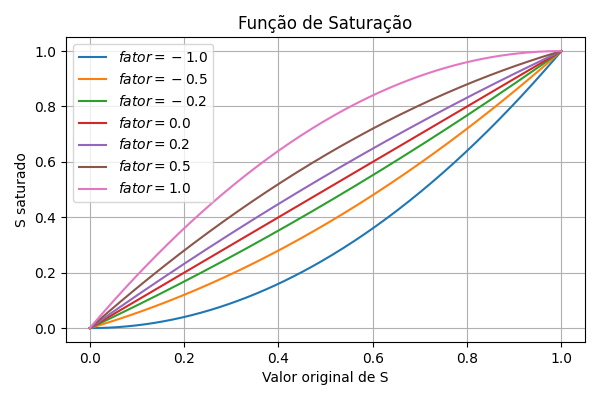

Na célula a seguir, complete o código da função `aprimora` para que implemente os passos aqui descritos.

- Parâmetros:

  - `img`: imagem RGB original (não deve aceitar imagem monocromática)

  - `f`: fator $f$, da fórmula acima

- Retorno:

  - Objeto `PIL Image`, em formato RGB

In [ ]:
################################ INÍCIO DO SEU CÓDIGO ##################
def converte_pil_para_hls(img):
  return cv2.cvtColor(np.asarray(img).astype(np.uint8), cv2.COLOR_RGB2HLS)


def alarga_contraste(l):
  return (((l - l.min()) / (l.max() - l.min())) * 255).astype(np.uint8)

################################ TÉRMINO DO SEU CÓDIGO ##################

def aprimora(img, f, alarg=False):
  assert img.mode == 'RGB'
  assert -2 <= f <= 2

  hls = converte_pil_para_hls(img)

  if alarg:
    hls[:,:,1] = alarga_contraste(hls[:,:,1])

  hls[:,:,2]  = np.clip(hls[:, :, 2] + f * (1 - hls[:, :, 2]), 0, 255).astype(np.uint8)

  return gera_imagem(cv2.cvtColor(hls, cv2.COLOR_HLS2RGB))
  ################################ COMPLETE COM SEU CÓDIGO ##################

#### **Testando sua solução**

Execute a célula a seguir para testar sua implementação.

In [ ]:
img = Image.open('imagens/igrejinha.png')
imgs = [img]
legs = ['Original']

fatores = np.arange(-2, 2.5, 0.5)

for f in fatores:
  imgAp = aprimora(img, f)
  imgs.append(imgAp)
  legs.append('f = %.1f' % f)

exibe_mosaico(imgs, legs, colunas=3)

---

# **Reconstruindo imagens**

Um hacker malicioso, porém amador, decidiu codificar uma série de imagens do banco de imagens de uma empresa que invadiu. A ideia do hacker era pedir um valor de "resgate" e, após pago, ele decodificaria as imagens de volta aos seus formatos originais.

A empresa então te contratou para analisar a situação e, se possível, desenvolver um algoritmo que permitisse fazer a decodificação.

Felizmente, o hacker era amador e seus conhecimentos eram bastante limitados e você rapidamente descobriu como reverter o processo.

O hacker substituiu os arquivos das imagens por outros, com a extensão `.hir`, onde foram salvos os dados codificados. Ao tentar abrir o arquivo, você descobriu que o mesmo estava em formato textual e possuía a seguinte estrutura:

- Na primeira linha do arquivo, estão 3 valores inteiros, separados por espaços. Após alguns testes, você deduziu que estes valores correspondem, respectivamente, à quantidade de linhas, quantidade de colunas e quantidade de canais da imagem. Nesta ordem

- Nas demais linhas, encontram-se strings contendo informação em um padrão amplamente conhecido e bastante difundido no meio do Desenvolvimento Web: a notação hexadecimal.

- Como esta notação é utilizada para representar cores RGB em um modelo mais compacto, foi natural deduzir que cada linha do arquivo (exceto a primeira) correspondia à informação de um pixel, que seria lido sequencialmente e alocado na matriz da imagem, de acordo com o número de linhas e colunas informados na primeira linha do arquivo.

- Um último detalhe que você notou foi que quando a quantidade de canais era 3, o valor do pixel era como em `#FF038D`, e quando a quantidade era 1, o valor do pixel era como em `#A8`.

Cabe a você implementar o código da função `decodifica`, abaixo, que reconstroi uma imagem a partir de um arquivo `.hir`.

A função recebe, como entrada, o nome do arquivo `.hir` e retorna um objeto `PIL Image` como resposta.

Para auxiliar na tarefa, já existe uma função pronta chamada `arq2list`, que recebe o nome do arquivo de entrada e retorna o seu conteúdo em uma lista, onde cada item corresponde a uma linha de texto do arquivo.

**A notação hexadecimal**

A representação hexadecimal utilizada nos arquivos `.hir` para denotar uma cor em formato RGB consiste em uma string de 7 caracteres, onde o primeiro caractere é uma *hashtag* (#) e os demais representam os valores de intensidade para cada canal.

Assim sendo, o primeiro par de caracteres representa um número hexadecimal para o canal vermelho, o segundo par representa um número hexadecimal para o canal verde e os dois últimos representa um número hexadecimal para o canal azul. Por exemplo:

- A string `#FF038D` representa a cor `(255, 3, 141)`, uma vez que $\mathrm{FF}_{hex} = 255_{dec}$, $\mathrm{03}_{hex} = 3_{dec}$ e $\mathrm{8D}_{hex} = 141_{dec}$

Já para uma imagem monocromática, a representação hexadecimal utilizada foi uma *hashtag* seguida de um par de caracteres representando o valor hexadecimal para uma dada intensidade de cinza. Por exemplo:

- A string `#A8` representa o tom 168, pois $\mathrm{A8}_{hex} = 168_{dec}$

In [ ]:
def arq2list(arq):
  fp = open(arq, 'r')
  linhas = []
  while True:
    linha = fp.readline().strip()
    if not linha:
      break
    linhas.append(linha)
  fp.close()

  return linhas

In [ ]:
def hex_to_rgb(hex, channels):
  nums = hex[1:]

  if channels == 1:
    nums = nums.rjust(2, '0')
    nums *= 3

  return [int(nums[0:2], 16), int(nums[2:4], 16), int(nums[4:6], 16)]

In [ ]:
def decodifica(arq):
  ################################ COMPLETE COM SEU CÓDIGO ##################
  linhas = arq2list(arq)

  h, w, ch = [int(v) for v in linhas[0].split(' ')]

  img = np.zeros((h, w, 3))

  for i, hex in enumerate(linhas[1:]):
    c = i % w
    l = i // w

    img[l, c, :] = hex_to_rgb(hex, ch)

  return gera_imagem(img)

#### **Testando seu código**

Execute a célula abaixo para testar sua solução. As imagens `.hir` estão na pasta `imagens/hir/`.

In [ ]:
pth = 'imagens/hir/'
imgs = []
legs = []
for arq in os.listdir(pth):

  if os.path.isfile(pth + arq) and arq.endswith('.hir'):
    img = decodifica(pth + arq)
    imgs.append(img)
    legs.append('Visualização do conteúdo de %s' % arq)

exibe_mosaico(imgs, legs)

---

# **Harmonização Facial**

Uma clínica de estética ficou sabendo de suas habilidades e resolveu te contratar para fazer um software que simula os resultados da harmonização facial que eles vendem como serviço.

Para tal, o cliente deve fornecer uma foto de si mesmo. A partir desta foto, sua solução deve montar duas propostas de harmonização. Para isto, os seguintes passos devem ser seguidos.

1. Cria-se uma cópia espelhada horizontalmente (isto é, com as colunas espelhadas) da imagem original

1. Na primeira versão da simulação, uma combinação da imagem original com a espelhada será feita, a fim de se produzir uma face com "dois lados esquerdos"

1. Na segunda versão da simulação, uma combinação da imagem espelhada com a original será feita, a fim de se produzir uma face com "dois direitos". Isto é, uma versão difere-se da outra apenas pela ordem das imagens

Exemplos:

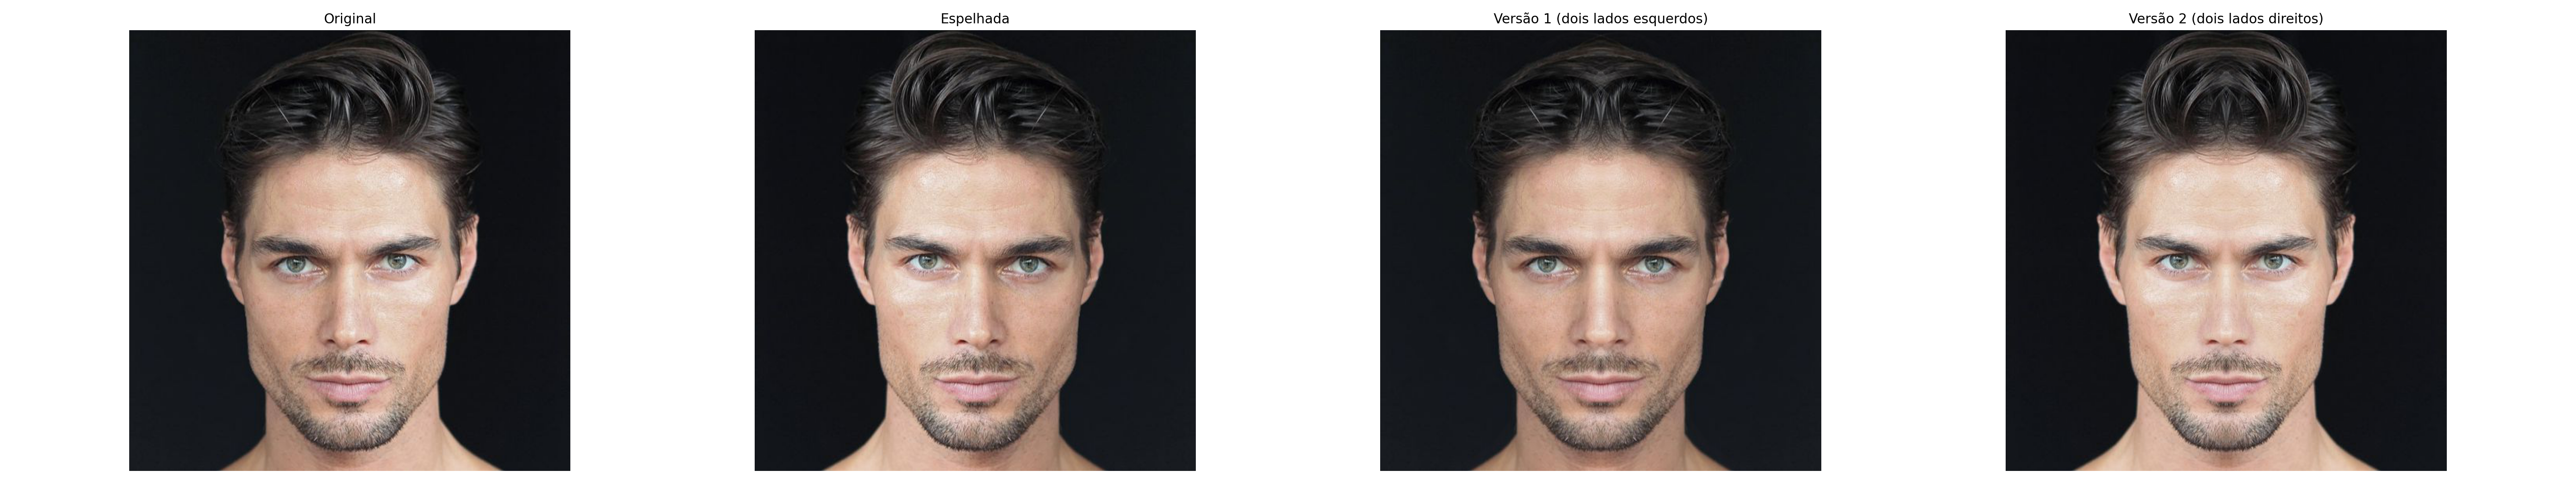

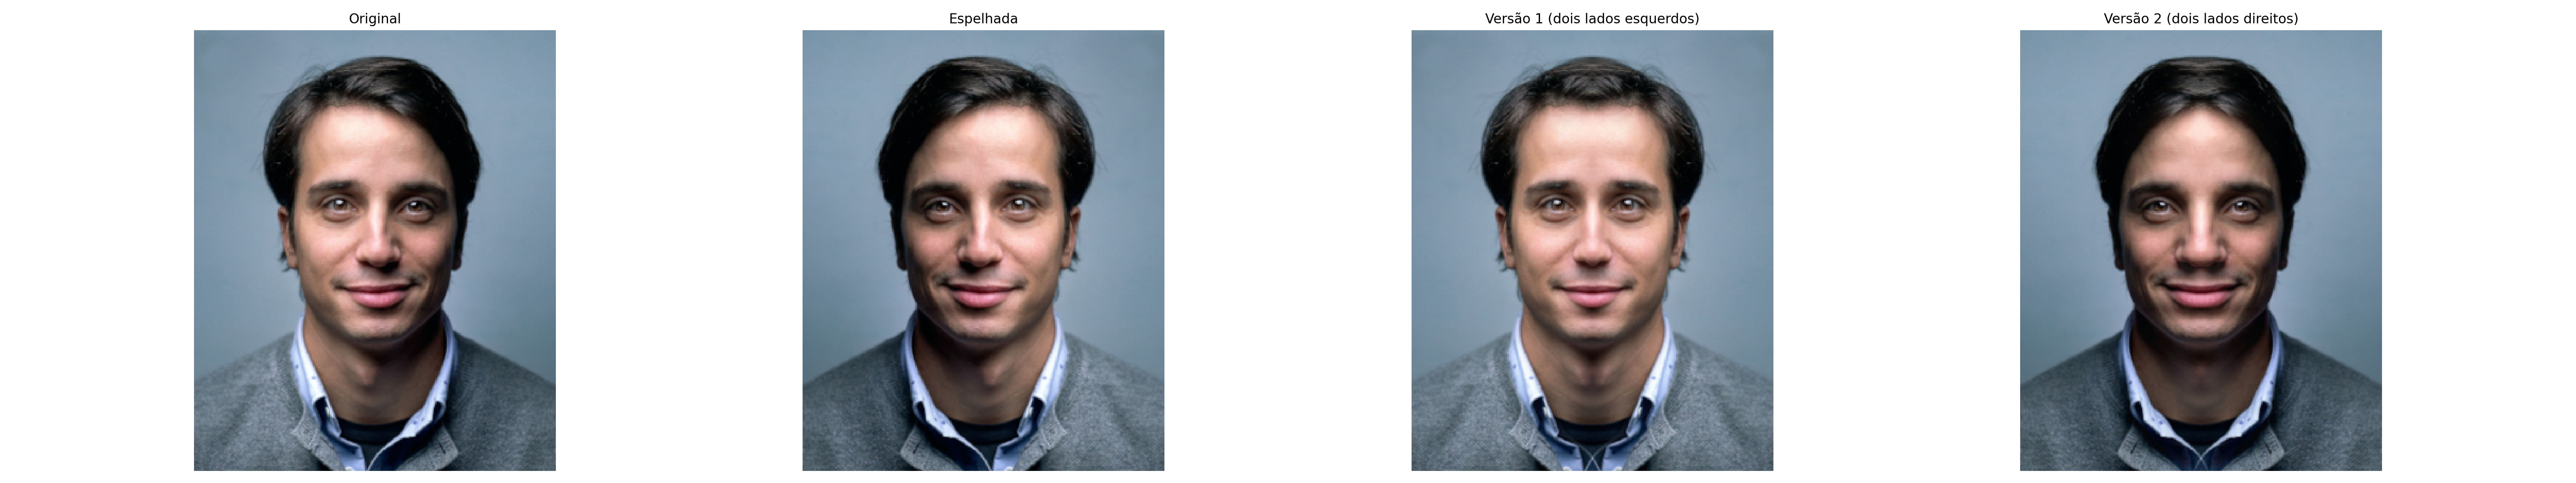

- As imagens produzidas devem ser combinadas usando uma função $\alpha(x)$, de ponderação, onde $x$ representa as colunas das imagens. Assim sendo, temos que:

- $C = \alpha(x) \cdot A + (1 - \alpha(x)) \cdot B$, onde:

  - $A$ e $B$ são as imagens de entrada

  - $C$ é a imagem resultante (a combinação)

  - $\alpha(x) = 1 - 0,5 \cdot \left [ 1 - \frac{arctan(a \cdot x - \frac{a}{2})}{arctan(\frac{-a}{2})} \right ]$

    - $a$, na fórmula acima, é um parâmetro informado pelo usuário, que controla como a transição entre uma imagem e outra se comportará

    - Valores pequenos de $a$ produzem transições tendendo à linearidade, e valores grandes produzem transições mais abruptas em torno do centro

    - Veja os exemplos de variações de $\alpha$ e $1 - \alpha$, para diferentes valores de $a$, a seguir:

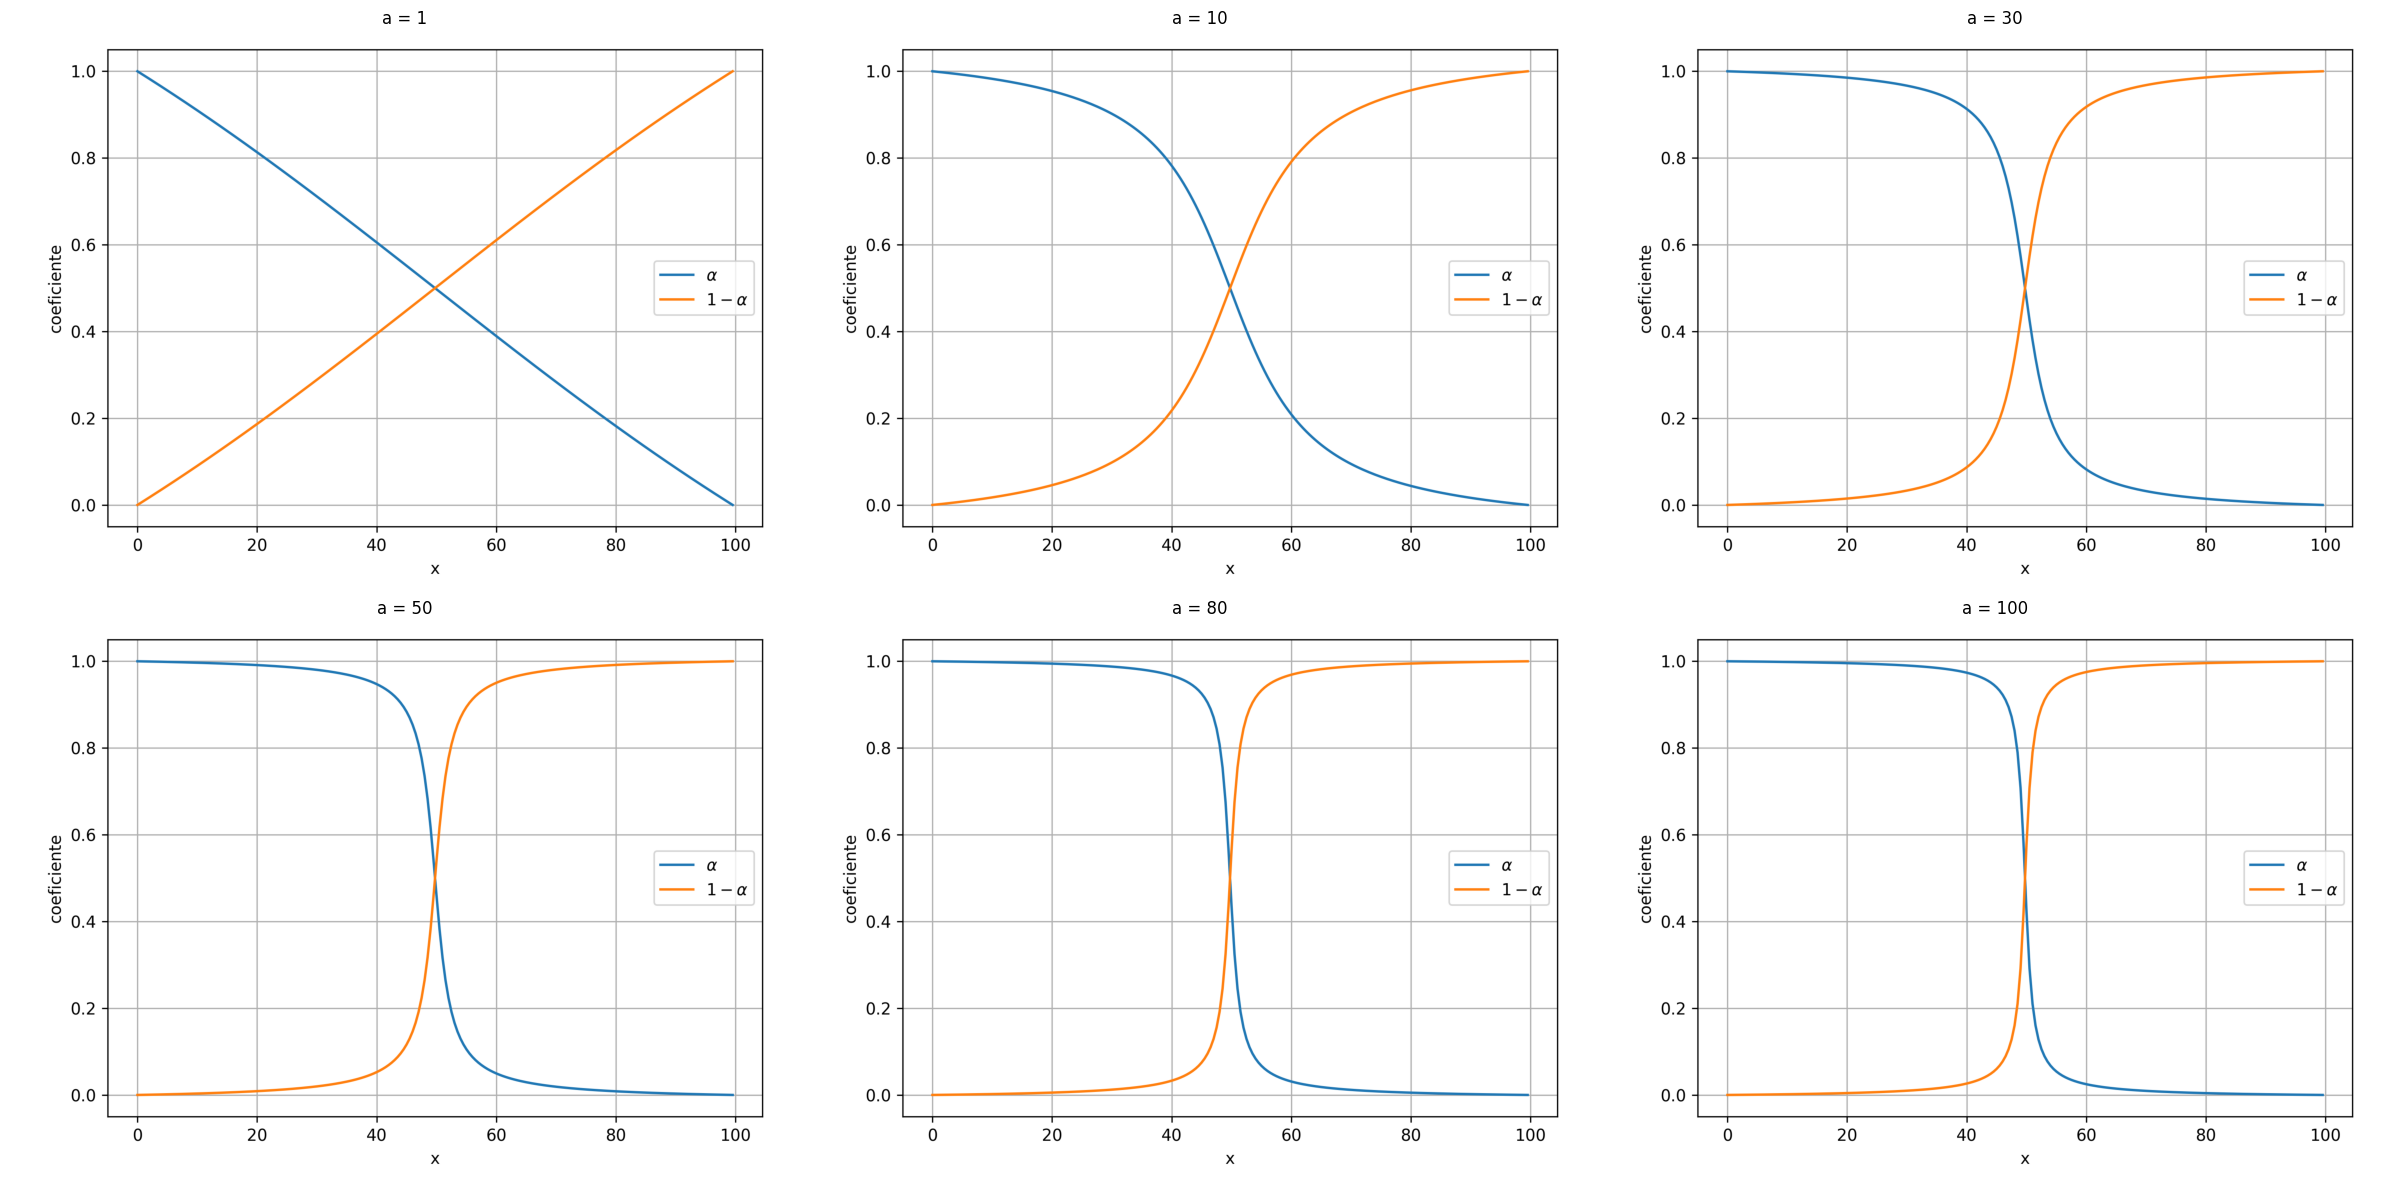

Implemente, abaixo, a função `combina`, que recebe como parâmetros os arrays das duas imagens e o parâmetro `a`, usado dentro de $\alpha(x)$. A função deve retornar um objeto `PIL Image`.

In [ ]:
def calc_alpha(x, a):
  return 1 - .5 * (1 - np.arctan(a * x - a/2)/np.arctan(-a / 2))


def combina(arr1, arr2, a):
  ################################ COMPLETE COM SEU CÓDIGO ##################
  rg_values = np.linspace(0, 1, arr1.shape[1])

  img_res = np.zeros(arr1.shape)

  for i, value in enumerate(rg_values):
    img_res[:, i, :] = calc_alpha(value, a) * arr1[:, i, :] + (1 - calc_alpha(value, a)) * arr2[:, i, :]

  return gera_imagem(img_res)


#### **Testando seu código**

Execute as duas células abaixo.

In [ ]:
A = [1, 10, 30, 50, 80, 100]

img = Image.open('imagens/moca.jpg')
arr = np.asarray(img).astype(float)

arrInv = arr[:,::-1,:]
imgInv = gera_imagem(arrInv)

imgs = [img, imgInv]
legs = ['Original', 'Espelhada']

for a in A:
  imgOut = combina(arr, arrInv, a)
  imgs.append(imgOut)
  legs.append('a = %d' % a)

exibe_mosaico(imgs, legs)


In [ ]:
imgs = [imgInv, img]
legs = ['Espelhada', 'Original']

for a in A:
  imgOut = combina(arrInv, arr, a)
  imgs.append(imgOut)
  legs.append('a = %d' % a)

exibe_mosaico(imgs, legs)


---

# **Preto no Branco (ou Branco no Preto?)**

A empresa ClosedAI está desenvolvendo um produto de Inteligência Artificial para análises variadas em imagens. Para auxiliar no treinamento da tarefa conhecida como Segmentação Semântica, é necessário que se produza máscaras que marquem regiões de interesse sobre certas imagens. Um passo importante para isso é a **binarização** de imagens.

Como consultor(a) contratado(a) pela ClosedAI, cabe a você produzir uma implementação do filtro de binarização de Otsu, conforme descrito nos slides das aulas teóricas.

Porém, na sua implementação, haverá um extra. Um parâmetro sentinela (*flag*), que informa se a imagem retornada será "invertida" ou não. Isto é, por padrão, a imagem será "branco sobre preto", mas caso o parâmetro seja informado como verdadeiro, a imagem retornada deve ser "preto sobre branco".

Implemente o código da função `otsu`.

Parâmetros:

- `img`: objeto `PIL Image`

- `inv`: parâmetro booleano, informando se o resultado será invertido ou não. Valor default: *falso*

Retorno:

- Objeto `PIL Image`, binarizado. Na verdade, será uma imagem "pseudo-binária", pois não será composta de bits, mas sim uma monocromática que só possui pixels com valores $0$ e $255$.

In [ ]:
def otsu(img, inv=False):
  ################################ COMPLETE COM SEU CÓDIGO ##################
  img_cinza = img.convert('L')
  img_cinza = np.array(img_cinza).astype(np.uint8)

  h, w = img_cinza.shape

  tot = h * w

  hist, _ = np.histogram(img_cinza.flatten(), bins=256, range=[0, 256])
  cdf = hist.cumsum()

  mu = sum(i * h for i, h in enumerate(hist)) / tot

  th = 0
  max_var = 0

  for i in range(1, 255):
    mu1 = sum(j * hist[j] / cdf[i] for j in range(i))
    mu2 = sum(j * hist[j] / (tot - cdf[i]) for j in range(i + 1, len(hist)))

    var = cdf[i] * (mu1 - mu) ** 2 + (tot - cdf[i]) * (mu2 - mu) ** 2

    if var > max_var:
      max_var = var
      th = i

  img_binaria = np.where(img_cinza > th, 255, 0)

  if inv:
    img_binaria = 255 - img_binaria

  return gera_imagem(img_binaria)


#### **Testando seu código**

Execute as duas células a seguir para testar sua implementação

In [ ]:
img = Image.open('imagens/lago.jpg')
img2 = Image.open('imagens/rio.jpg')

imgBin = otsu(img)
imgBinInv = otsu(img, inv=True)
imgBin2 = otsu(img2)
imgBin2Inv = otsu(img2, inv=True)

imgs = [img, imgBin, imgBinInv, img2, imgBin2, imgBin2Inv]
legs = ['Original', 'Binária', 'Binária Invertida', 'Original', 'Binária', 'Binária Invertida']

exibe_mosaico(imgs, legs, colunas=3)

In [ ]:
img = Image.open('imagens/moca.jpg')
img2 = Image.open('imagens/igrejinha.png')

imgBin = otsu(img)
imgBin2 = otsu(img2)

exibe_mosaico([img, imgBin, img2, imgBin2], ['Original', 'Binária', 'Original', 'Binária'])

---

# **Fora das redes sociais, você está bem?**

Uma rede social de postagem de imagens conhecida como Estragam te contratou para desenvolver um novo filtro para que os usuários utilizem nas fotos que irão postar.

O filtro consiste em uma aplicação que já fizemos em sala, porém com versões distintas. É o fitro que chamamos de "destaque de cor", onde uma cor de interesse é selecionada e uma margem de tolerância ($\delta$) é definida Todos pixels cujas cores que são similares à de referência por um fator menor que $\delta$, têm seus valores de intensidade preservados, enquanto os demais são substituídos por suas versões em tons de cinza.

No entanto, estudamos em sala de aula que computar distâncias de cores pode ser algo traiçoeiro. Vamos testar a aplicação do filtro em diferentes espaços de cores.

Na aula prática de 02/05/2023, foram implementadas versões deste filtro para o espaço RGB e HSV. Vamos agora repetir o espaço RGB, mas comparar seus resultados com os espaços HSL e CIE-Lab.

A conversão HSL --> RGB e vice-versa, você já implementou para um exercício anterior. Basta utilizar a mesma solução para implementação do filtro aqui. Já as conversões para o espaço CIE-Lab e vice-versa, podem ser encontradas prontas dentro da biblioteca `skimage.color` (já está importada no preâmbulo com o alias `color`), nas funções `rgb2lab` e `lab2rgb`.

Algumas observações sobre a conversão pra CIE-Lab:

- Primeiro, não se preocupe se alguns *warnings* sobre valores inválidos forem lançados devido ao uso das funções de conversão. Isso não afetará o resultado.

- Um passo importante é que, ao se extrair o array de dados da imagem, o *cast* de tipo seja feito para `np.uint8`, ao invés dos tradicionais `int` ou `float`.

- O array de entrada em RGB para a função `rgb2lab` deve estar normalizado no intervalo $[0,1]$. Isto é, divida o array todo por $255$ antes de passá-lo para a função.

- Por fim, de maneira coerente com a observação anterior, o resultado retornado pela função `lab2rgb` também retorna um array de valores no intervalo $[0,1]$. Portanto, vc deve ajustar os valores para que produzam uma imagem válida depois.

Implemente o corpo das funções `destaque_corRGB`, `destaque_corHSL` e `destaque_corLAB`, a seguir. Os parâmetros para as três são os mesmos:

- `img`: imagem `PIL Image` de entrada

- `ref`: *numpy array*, de dimensões $1 \times 3$, contendo os valores RGB da cor de referência

- `delta`: o parâmetro de tolerância $\delta$, mencionado no enunciado

Retorno (para todas 3):

- Objeto `PIL Image`, resultante do efeito aplicado.

In [ ]:
def destaque_corRGB(img, ref, delta):
  ################# COMPLETE COM SEU CÓDIGO #####################
  arr = np.asarray(img).astype(np.uint8)
  arr_c = np.dot(arr.copy(), [0.299, 0.587, 0.114])
  arr_c = np.dstack([arr_c]*3)

  arr_dist = np.sqrt(np.sum((arr - ref)**2, axis=2))
  arr_dist = (arr_dist - arr_dist.min()) / (arr_dist.max() - arr_dist.min())

  arr_c[arr_dist <= delta] = arr[arr_dist <= delta]

  return gera_imagem(arr_c)


In [ ]:
def calc_dist_hsl(arr_hls, ref):
  h1, l1, s1 = cv2.split(arr_hls)
  h2, l2, s2 = cv2.cvtColor(np.uint8([[ref]]), cv2.COLOR_RGB2HLS)[0, 0]

  h1 = h1.astype(np.float32) * 2 * np.pi / 180
  h2 = h2.astype(np.float32) * 2 * np.pi / 180

  delta_h = np.abs(h1 - h2)
  delta_h = np.minimum(delta_h, 2 * np.pi - delta_h)

  delta_s = s1.astype(np.float32) - s2.astype(np.float32)
  delta_l = l1.astype(np.float32) - l2.astype(np.float32)

  return np.sqrt(delta_h ** 2 + delta_s ** 2 + delta_l ** 2)


def destaque_corHSL(img, ref, delta):
  ################# COMPLETE COM SEU CÓDIGO #####################
  arr = np.asarray(img).astype(np.uint8)
  arr_c = np.dot(arr.copy(), [0.299, 0.587, 0.114]).astype(np.uint8)
  arr_c = np.dstack([arr_c]*3)

  arr_hls = cv2.cvtColor(arr, cv2.COLOR_RGB2HLS)
  arr_c_hls = cv2.cvtColor(arr_c, cv2.COLOR_RGB2HLS)

  arr_dist = calc_dist_hsl(arr_hls, ref)
  arr_dist = (arr_dist - arr_dist.min()) / (arr_dist.max() - arr_dist.min())

  arr_c_hls[arr_dist <= delta] = arr_hls[arr_dist <= delta]

  return gera_imagem(cv2.cvtColor(arr_c_hls, cv2.COLOR_HLS2RGB))


In [ ]:
def calc_dist_lab(arr_lab, ref_lab):
  return np.linalg.norm(arr_lab.astype(np.float32) - ref_lab.astype(np.float32), axis=2)


def destaque_corLAB(img, ref, delta):
  ################# COMPLETE COM SEU CÓDIGO #####################
  arr = np.asarray(img).astype(np.uint8)
  arr_c = np.dot(arr.copy(), [0.299, 0.587, 0.114]).astype(np.uint8)
  arr_c = np.dstack([arr_c] * 3)

  arr_lab = cv2.cvtColor(arr, cv2.COLOR_RGB2LAB)
  arr_c_lab = cv2.cvtColor(arr_c, cv2.COLOR_RGB2LAB)

  ref_lab = cv2.cvtColor(np.uint8([[ref]]), cv2.COLOR_RGB2LAB)[0, 0]

  arr_dist = calc_dist_cielab(arr_lab, ref_lab)
  arr_dist = (arr_dist - arr_dist.min()) / (arr_dist.max() - arr_dist.min())

  arr_c_lab[arr_dist <= delta] = arr_lab[arr_dist <= delta]

  return gera_imagem(cv2.cvtColor(arr_c_lab, cv2.COLOR_LAB2RGB))


#### **Testando seu código**

Execute as duas células a seguir, para testar sua solução.

In [ ]:
refs = np.array(
    [
        [139, 1, 1],
        [3, 226, 101],
        [254, 203, 146],
        [203, 87, 87],
        [60, 15, 20]
    ]
)

deltas = [0.1, 0.3, 0.5]

In [ ]:
img = Image.open('imagens/tamburutaca.jpg')
for ref in refs:
  arrRef = np.zeros((32, 32, 3)) + ref
  imgRef = gera_imagem(arrRef)
  display(imgRef)
  for delta in deltas:
    imgs = [img]
    legs = ['Original']

    destRGB = destaque_corRGB(img, ref, delta)
    destHSL = destaque_corHSL(img, ref, delta)
    destLAB = destaque_corLAB(img, ref, delta)

    imgs.append(destRGB)
    imgs.append(destHSL)
    imgs.append(destLAB)

    legs.append('RGB. Cor: [%d, %d, %d]. Delta: %.1f' % (ref[0], ref[1], ref[2], delta))
    legs.append('HSL. Cor: [%d, %d, %d]. Delta: %.1f' % (ref[0], ref[1], ref[2], delta))
    legs.append('LAB. Cor: [%d, %d, %d]. Delta: %.1f' % (ref[0], ref[1], ref[2], delta))

    exibe_mosaico(imgs, legs)
    print()

---

# **Onda retrô**

A empresa Ubihard desenvolve games com visual "retrô". Os jogos são do tipo "história interativa", onde o jogador toma decisões pelos personagens em momentos chave da narrativa e a história vai mudando/adaptando de acordo com as decisões.

Para produzir o visual retrô, a técnica que eles utilizam é filmar atores dramatizando as cenas e depois, em pós-processamento, aplicar filtros que produzam um efeito visual de "Pixel Art".

Cabe a você desenvolver o efeito para eles. No caso, o efeito é aplicado a cada frame de vídeo, o que equivale a aplicar o efeito sobre um conjunto de fotos separadas.

O efeito consiste nas seguintes etapas:

1. Para dar um efeito mais próximo de desenho, podemos mexer com a saturação das cores, pois desenhos costumam apresentar cores bem vivas. Neste primeiro passo utilizaremos, então, a função `aprimora`, que você desenvolveu para o exercício "Agora é a vez das crianças".

1. Após o aprimoramento das cores, vamos reduzir também o nível de detalhe da imagem. Para isso, vamos utilizar o filtro de suavização da mediana, que remove detalhes da imagem, porém preservando melhor as bordas dos objetos do que outros filtros de suavização. Por padrão, vamos utilizar uma janela de suavização de tamanho = 5. Implemente o código da função `mediana`, a seguir.

  - Parâmetros de entrada: `imgOrig`, um objeto `PIL Image` e `janela`, o tamanho da janela da vizinhança.

  - Retorno: imagem `PIL Image` com o resultado da suavização

1. O próximo passo consiste em aplicar uma pixelização. Porém, não vamos utilizar a pixelização feita em aula prática. Vamos implementar uma nova abordagem.

  - Foi importado, da biblioteca `skimage.segmentation`, uma função chamada `slic`, que implementa um método que emprega um algoritmo de clusterização para agrupar os pixels de uma imagem levando em conta tanto a similaridade de cores, quanto a proximidade geométrica entre os mesmos.

  - Vamos utilizar dois parâmetros da função: `n_segments`, que informa a quantidade de grupos que iremos produzir, e `compactness`, que controla o balanço de importância entre as similaridades de cores e proximidade espacial. Valores altos indicam que a prioridade é para a proximidade espacial, tendendo a produzir agrupamentos (superpixels) de formato mais retangular.

  - A função `slic` retorna um array, de mesmo formato da imagem, onde cada célula contém um valor inteiro, representando o "id" de qual agrupamento aquele pixel pertence.

  - Usando o "mapeamento" entregue pela função `slic`, substitua os valores de todos pixels daquela região pela média das cores dos pixels daquela mesma região.

  - Implemente o código da função `pixelizaSlic` abaixo, que recebe como parâmetros: `img`, a imagem `PIL` de entrada; `percent`, o percentual de pixels da imagem que determinará a quantidade de grupos; e `compactacao`, que será repassado para o parâmetro `compactness`, da função `slic`. O número de grupos deve ser calculado como sendo:

  - $\mathrm{ng} = \mathrm{arred}(\mathrm{percent} \cdot T)$, onde $arred$ é uma função de arredondamento e $T$ é o total de pixels da imagem. O valor $ng$ será repassado para o parâmetro `n_segments`, da função `slic`.

  - O retorno de `pixelizaSlic` deve ser um objeto `PIL Image`.

1. Por fim, para trabalhar com uma paleta de cores reduzida, aplicamos o método de quantização *median-cut* (implementada na solução do problema "Economizando tinta") sobre a imagem pixelizada.

Estes passos todos são evocado pela função `pixelArt`, que já se encontra pronta. Implemente, portanto, o corpo das funções `mediana` e `pixelizaSlic`.
    

In [ ]:
def mediana(imgOrig, janela=5):
  ################################ COMPLETE COM SEU CÓDIGO ##################

In [ ]:
def pixelizaSlic(img, percent, compactacao=300):
  ################################ COMPLETE COM SEU CÓDIGO ##################

In [ ]:
def pixelArt(imgOrig, ntons=128, f=1.1, alarg=False, janela=7, percent=0.03, compac=500):
  img = aprimora(imgOrig, f, alarg)
  img = mediana(img, janela)
  img = pixelizaSlic(img, percent, compac)
  return median_cut(img, ntons)

#### **Testando seu código**

Execute a célula abaixo para testar sua implementação.

In [ ]:
arqs = ['capivara.png', 'igrejinha.png', 'moca.jpg', 'tamburutaca2.jpg']
imgs = []
legs = []

for arq in arqs:
  img = Image.open('imagens/' + arq)
  imgs.append(img)
  legs.append('Original')

  imgArt = pixelArt(img)
  imgs.append(imgArt)
  legs.append('Pixel Art (valores default)')

exibe_mosaico(imgs, legs)

---

# **Operação Capivara**

Uma agência de inteligência secreta, chamada SIA, interceptou uma mensagem criptografada e a salvou em um arquivo. Junto com a transmissão da mensagem, foram interceptadas as transmissões de 16 imagens de capivaras, onde, na verdade tem-se 8 imagens diferentes com 1 cópia de cada uma delas, ou seja, existem 8 pares de imagens aparentemente iguais, a olho nu.

No entanto, um analista de sistema da SIA notou que, embora pareçam idênticas, alguns pares de imagens possuem diferenças interna entre as imagens do par, enquanto outra não.

Suspeita-se de que os pares que não têm imagens idênticas possam carregar alguma informação que auxilie descriptografar a mensagem interceptada, embutida, possivelmente, sob a forma de um ruído muito sutil, imperceptível ao olho humano.

Conhecendo suas habilidades com processamento de imagens, a agência te contratou como consultor para auxiliá-los a decodificar a mensagem final.

Para isso, você deve:

1. Identificar quais pares de imagens apresentam diferenças entre as imagens do par

1. Para cada par com diferenças, encontrar uma forma de visualizar esta diferença de forma isolada e visível a olho nu, e verificar se há alguma informação visual útil que possa auxiliar na descriptação do arquivo de mensagem.

1. Havendo informações úteis, como se suspeita, segui-las para decriptar o arquivo.

Informações adicionais:

- As imagens de capivaras estão na pasta `imagens/cripto/`, com nomes padronizados com `capivaraDD.png`, onde `DD` é um número inteiro incremental.

- Na mesma pasta, está o arquivo da mensagem, com o nome de `msg.npy`, e foi salvo usando o método `np.save` com o parâmetro `allow_pickle` definido como verdadeiro. Portanto, para carregar o array deste arquivo deve-se utilizar o método `np.load`, também com o parâmetro `allow_pickle` definido como verdadeiro.

Implemente sua solução completa na célula a seguir. Você está livre para adicionar células a mais, implementar funções, importar bibliotecas e o que julgar necessário para resolver o problema.

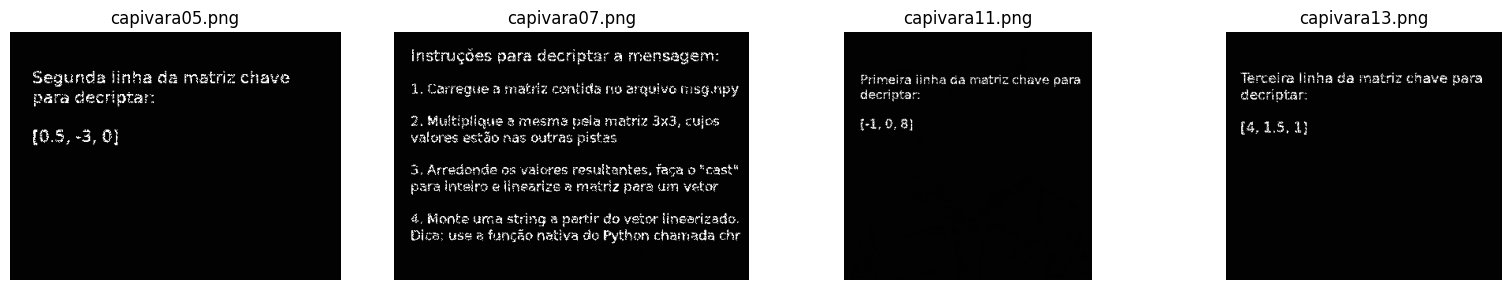

In [270]:
################################ COMPLETE COM SEU CÓDIGO ##################
images_paths = [os.path.join('imagens/cripto', arq) for arq in os.listdir('imagens/cripto') if arq.endswith('.png')]
images_paths.sort()

imgs = []
legs = []

for i in range(0, len(images_paths), 2):
  img_res = np.abs(np.asarray(Image.open(images_paths[i]))-np.asarray(Image.open(images_paths[i+1])))

  if not np.all(img_res == 0):
    res = np.asarray(Image.fromarray(img_res).convert('L'))
    res[res > 10] = 255
    imgs.append(gera_imagem(res))
    legs.append(images_paths[i].split('/')[-1])

exibe_mosaico(imgs, legs)

In [271]:
aux_array = np.array([[-1, 0, 8], [.5, -3, 0], [4, 1.5, 1]])

msg = np.load('imagens/cripto/msg.npy', allow_pickle=True)

msg = np.matmul(msg, aux_array).flatten().round().astype(np.uint8)

''.join([chr(char) for char in msg])

'Parabéns!!\nVocê decifrou a mensagem final!!\nINF 394 - 2023/1'

- Responda, na célula a seguir, qual foi a mensagem que você encontrou após a descriptação. (execute a célula antes de responder)

In [269]:
#@title
def aceitacao(e):
  with output:
    md = Markdown('#### **Resposta salva.**')
    display(md)

txt = Markdown('#### **Atenção:** Execute esta célula clicando no botãozinho de "play", antes de preencher e salvar sua resposta!')
rotulo = widgets.Label(display(txt))
display(rotulo)

resposta = widgets.Textarea(
    value='',
    placeholder='Escreva aqui sua resposta',
    description='Resposta:',
    rows=5,
    layout=widgets.Layout(width='800px')
)
display(resposta)

output = widgets.Output()
display(output)

botao = widgets.Button(
    description='Salvar resposta'
)
botao.on_click(aceitacao)

display(botao)

#### **Atenção:** Execute esta célula clicando no botãozinho de "play", antes de preencher e salvar sua resposta!

Label(value='')

Textarea(value='', description='Resposta:', layout=Layout(width='800px'), placeholder='Escreva aqui sua respos…

Output()

Button(description='Salvar resposta', style=ButtonStyle())

---

# **Quem apagou a luz?**

Uma empresa de armazenamento de documentos (sim, existe isso na vida real...) fotografou 4 documentos para serem inseridos no seu banco de imagens. No entanto, o operador que fez as aquisições era novato e não entendia muito bem a importância da iluminação para a qualidade visual de uma foto.

Execute a célula abaixo para visualizar as quatro fotografia (estão na pasta `imagens/textos/`).

In [ ]:
pth = 'imagens/textos/'

imgs = []
legs = []

for arq in os.listdir(pth):
  img = Image.open(pth + arq)
  imgs.append(img)
  legs.append(arq)

exibe_mosaico(imgs, legs)

- Na célula a seguir, aplique a técnica de alargamento de contraste a cada uma das imagens e exiba os resultados.

In [ ]:
################################ COMPLETE COM SEU CÓDIGO ##################
pth = 'imagens/textos/'

imgs = []
legs = []

for arq in os.listdir(pth):
  img = gera_imagem(alarga_contraste(np.array(Image.open(pth + arq).convert('L'))))

  imgs.append(img)
  legs.append(arq)

exibe_mosaico(imgs, legs)

- O resultado ficou bom? Por que? (execute a célula abaixo antes de responder)

In [272]:
#@title
def aceitacao(e):
  with output:
    md = Markdown('#### **Resposta salva.**')
    display(md)

txt = Markdown('#### **Atenção:** Execute esta célula clicando no botãozinho de "play", antes de preencher e salvar sua resposta!')
rotulo = widgets.Label(display(txt))
display(rotulo)

resposta = widgets.Textarea(
    value='',
    placeholder='Escreva aqui sua resposta',
    description='Resposta:',
    rows=5,
    layout=widgets.Layout(width='800px')
)
display(resposta)

output = widgets.Output()
display(output)

botao = widgets.Button(
    description='Salvar resposta'
)
botao.on_click(aceitacao)

display(botao)

#### **Atenção:** Execute esta célula clicando no botãozinho de "play", antes de preencher e salvar sua resposta!

Label(value='')

Textarea(value='', description='Resposta:', layout=Layout(width='800px'), placeholder='Escreva aqui sua respos…

Output()

Button(description='Salvar resposta', style=ButtonStyle())

- Na célula a seguir, aplique a função `otsu` que você desenvolveu anteriormente em cada uma das imagens e exiba o resultado.

In [ ]:
################################ COMPLETE COM SEU CÓDIGO ##################
pth = 'imagens/textos/'

imgs = []
legs = []

for arq in os.listdir(pth):
  img = otsu(Image.open(pth + arq))

  imgs.append(img)
  legs.append(arq)

exibe_mosaico(imgs, legs)

- Qual o problema com os resultados? Por que você acha que isso aconteceu? (execute a célula a seguir antes de responder)

In [273]:
#@title
def aceitacao(e):
  with output:
    md = Markdown('#### **Resposta salva.**')
    display(md)

txt = Markdown('#### **Atenção:** Execute esta célula clicando no botãozinho de "play", antes de preencher e salvar sua resposta!')
rotulo = widgets.Label(display(txt))
display(rotulo)

resposta = widgets.Textarea(
    value='',
    placeholder='Escreva aqui sua resposta',
    description='Resposta:',
    rows=5,
    layout=widgets.Layout(width='800px')
)
display(resposta)

output = widgets.Output()
display(output)

botao = widgets.Button(
    description='Salvar resposta'
)
botao.on_click(aceitacao)

display(botao)

#### **Atenção:** Execute esta célula clicando no botãozinho de "play", antes de preencher e salvar sua resposta!

Label(value='')

Textarea(value='', description='Resposta:', layout=Layout(width='800px'), placeholder='Escreva aqui sua respos…

Output()

Button(description='Salvar resposta', style=ButtonStyle())

- Aplique a técnica de Limiar Variável às imagens, na célula a seguir (dica: implemente uma função para esta tarefa e teste a técnica com diferentes parâmetros).

In [ ]:
################################ COMPLETE COM SEU CÓDIGO ##################

def gen_limiar_var(img, args):
  img_c = np.array(img.convert('L'))

  img_res = np.zeros_like(img_c, dtype=np.uint8)

  for i in range(img_c.shape[0]):
    for j in range(img_c.shape[1]):
      p = img_c[i, j]
      vizinhanca_p = img_c[max(0, i - args[2]) : min(img_c.shape[0], i + args[2] + 1), max(0, j - args[2]) : min(img_c.shape[1], j + args[2] + 1)]
      sigma_viz_p = np.std(vizinhanca_p)
      mu_viz_p = np.mean(vizinhanca_p)
      limiar_p = args[0] * sigma_viz_p + args[1] * mu_viz_p

      img_res[i,j] = 255 if p > limiar_p else 0

  return gera_imagem(img_res)

pth = 'imagens/textos/'

func_args = [
    [.2, .5, 3], # a, b, t
    [.5, .5, 5],
    [.5, 1, 15],
    [.1, .3, 20]
]

imgs = []
legs = []

for args in func_args:
  for arq in os.listdir(pth):
    img = gen_limiar_var(Image.open(pth + arq), args)

    imgs.append(img)
    legs.append(arq + ' using args ' + str(args))

exibe_mosaico(imgs, legs)

- E agora? Como ficou o resultado? Por que ficou diferente do caso anterior? (execute a célula abaixo antes de responder)

In [274]:
#@title
def aceitacao(e):
  with output:
    md = Markdown('#### **Resposta salva.**')
    display(md)

txt = Markdown('#### **Atenção:** Execute esta célula clicando no botãozinho de "play", antes de preencher e salvar sua resposta!')
rotulo = widgets.Label(display(txt))
display(rotulo)

resposta = widgets.Textarea(
    value='',
    placeholder='Escreva aqui sua resposta',
    description='Resposta:',
    rows=5,
    layout=widgets.Layout(width='800px')
)
display(resposta)

output = widgets.Output()
display(output)

botao = widgets.Button(
    description='Salvar resposta'
)
botao.on_click(aceitacao)

display(botao)

#### **Atenção:** Execute esta célula clicando no botãozinho de "play", antes de preencher e salvar sua resposta!

Label(value='')

Textarea(value='', description='Resposta:', layout=Layout(width='800px'), placeholder='Escreva aqui sua respos…

Output()

Button(description='Salvar resposta', style=ButtonStyle())

---

# **Mono~tonia~cromática**

Lembra daquela gráfica? Pois é, te contrataram novamente. Mas agora querem produzir pôsteres com imagens moncromáticas. Porém, não na escala do cinza, mas na escala de uma cor base qualquer. Estas imagens monocromáticas são obtidas a partir de fotos RGB comuns.

Pode-se seguir dois caminhos, entre muitas possibilidades:

### **Abordagem 1:**

A partir de uma imagem de entrada $I$ e uma cor base $r$:

1. Cria-se um array, no mesmo formato de $I$, porém todo preenchido com $r$, produzindo-se $I_{r}$

1. Converte-se $I$ para monocromática em tons de cinza, usando a técnica de *luminosity*, produzindo-se $I_{c}$

1. Normaliza-se $I_{c}$ para que seus valores fiquem no intervalo $[0,1]$, produzindo-se $I_{n}$

1. Essa imagem normalizada servirá como pesos de ajustes de nuâncias sobre a cor base, fazendo-se: $I_{m} = I_{r} \cdot I_{n}$, onde o produto $\cdot$ é um produto de arranjo matricial, não um produto de matrizes

1. Produz-se uma imagem a partir de $I_{m}$

Implemente o corpo da função `monoNorm` a seguir, que recebe a imagem `img` de entrada e a cor `corRef` que será a base para a geração da imagem moncromática.

O parâmetro `corRef` deve ser um array $1 \times 3$ de valores inteiros, representando os canais RGB.

O retorno da função é uma imagem `PIL`.

### **Abordagem 2:**

A partir de uma imagem de entrada $I$, uma cor base $r$ e um fator de intensificação $f$:

1. Normalize os valores de $r$ para o intervalo $[0,1]$, produzindo $r_{n}$

1. Faça o produto de matrizes entre o vetor $T_{c}$ e $r_{n}$, produzindo $T$. O vetor $T_{c}$ é o mesmo que usamos para fazer a conversão em cinza usando a técnica de *luminosity*.

1. Multiplique $T$ pelo fator $f$, atualizando o valor de $T$. Temos, agora, uma matriz de transformação como a que foi usada em aula prática para produzir o efeito "sépia" nas imagens, mas ajustada para produzir o resultado monocromático com base na cor $r$ informada.

1. Aplique a transformação $T$ sobre a imagem, isto é, faça o produto entre os dados da imagem e $T$, produzindo $I_{m}$.

1. Produz-se uma imagem a partir de $I_{m}$

Implemente o corpo da função `monoMatriz` a seguir, que recebe a imagem `img` de entrada, a cor `corRef` que será a base para a geração da imagem moncromática, e o fator de intensificação `f`.

O parâmetro `corRef` deve ser um array $1 \times 3$ de valores inteiros, representando os canais RGB.

O retorno da função é uma imagem `PIL`.

In [ ]:
def monoNorm(img, corRef):
  ################################ COMPLETE COM SEU CÓDIGO ##################
  w, h = img.size

  img_cinza = np.array(img.convert('L'))
  img_ref = np.zeros((h, w, 3))
  img_ref[:, :, :] = corRef

  img_cinza = np.expand_dims(img_cinza / 255., axis=2)

  return gera_imagem(img_cinza * img_ref)

In [ ]:
def monoMatriz(img, corRef, f):
  ################################ COMPLETE COM SEU CÓDIGO ##################
  ref = np.array(corRef) / 255.
  t = np.outer(np.array([0.299, 0.587, 0.114]), ref)

  return gera_imagem(np.dot(np.array(img), t * f))


#### **Testando seu código**

Teste sua implementação executando as duas células a seguir.

In [ ]:
def exibeMonos(img, corRef, f):
  imgs = [img]
  legs = ['Original']

  arr = np.zeros_like(np.asarray(img).astype(int)) + corRef
  imgs.append(gera_imagem(arr))
  legs.append('Cor de Referência')

  imgMonoMat = monoMatriz(img, corRef, f)
  imgMonoNorm = monoNorm(img, corRef)

  imgs.append(imgMonoMat)
  legs.append('Transformação Matricial')
  imgs.append(imgMonoNorm)
  legs.append(r'Cor de Ref. $\times$ Luminosity Normalizada')

  exibe_mosaico(imgs, legs)

In [ ]:
cores = [
    [255, 35, 102],
    [216, 106, 55],
    [14, 6, 93],
    [109, 43, 11]
    ]
cores = np.array(cores)
imagens = ['igrejinha.png', 'moca.jpg']

for imagem in imagens:
  for corRef in cores:
    img = Image.open('imagens/' + imagem)
    exibeMonos(img, corRef, f=1.2)


---

# **Canny Valley**

<i>"O vale da estranheza (em inglês: uncanny valley) é uma hipótese no campo da estética, robótica e computação gráfica que diz que quando réplicas humanas se comportam de forma muito parecida — mas não idêntica — a seres humanos reais, provocam repulsa entre observadores humanos."</i> [referência](https://pt.wikipedia.org/wiki/Vale_da_estranheza)

Ao invés de produzir imagens que caiam no *uncanny valley*, vamos produzir imagens que estão longe disso, por serem muito diferentes do resultado original. Vamos apenas detectar bordas.

Para isso, vamos implementar o filtro de Canny (daí o *Canny Valley* do título 😬)...

A função principal, `canny`, já se encontra implementada. Porém ela depende de outras funções, as quais você deve implementar. São elas:

- `cinza_lum`: conversão para cinza, por *luminosity*. Recebe uma imagem e retorna uma imagem.

- `suaviza`: implementa a suavização gaussiana sobre a imagem moncromática obtida no passo anterior. Procure nos notebooks de aulas (práticas ou não) por essa solução. Recebe uma imagem e o tamanho do kernel gaussiano como entrada e retorna uma imagem como saída.

- `sobel`: implementa o filtro de Sobel. Recebe uma imagem como entrada. Porém, ao invés de retornar os valores tradicionais, retornará duas matrizes. A de magnitudes e a dos ângulos. Dicas: veja as documentações das funções `np.hypot` e `np.arctan2`...

- `sup_nao_max`: implementa a supressão de não máximo, descrita nos slides de aula. Recebe o array de magnitudes e o de ângulos como entrada. Retorna a matriz $Z$, de acordo com a definição dada nos slides.

- `duplo_limiar`: implementa o duplo limiar, também descrito nos slides. Recebe a matriz $Z$ e os limiares `alfa` e `beta` (ver slides). Retorna a matriz $R$ e os valores para $f$ e $F$ (ver slides).

- `histerese`: implementa a técnica de histerese, conforme mostrado em aula (ver slides). Recebe a matriz $R$ e os valores $f$ e $F$ e retorna a matriz $R$ filtrada, que será usada para gerar a imagem final.

Os parâmetros da função `canny`, já pronta, são:

- `img`: imagem de entrada
- `tam`: tamanho do kernel gaussiano para o filtro de Sobel
- `alfa`: limiar $\alpha$, do duplo limiar
- `beta`: limiar $\beta$, do duplo limiar



In [ ]:
def cinza_lum(img):
  ################################ COMPLETE COM SEU CÓDIGO ##################
  return img.convert('L')

In [ ]:
def suaviza(img, tam):
  ################################ COMPLETE COM SEU CÓDIGO ##################
  return cv2.GaussianBlur(img, (tam, tam), 0)


In [ ]:
def sobel(img):
  ################################ COMPLETE COM SEU CÓDIGO ##################


In [ ]:
def sup_nao_max(G, angulos):
  ################################ COMPLETE COM SEU CÓDIGO ##################


In [ ]:
def duplo_limiar(Z, alfa, beta):
  ################################ COMPLETE COM SEU CÓDIGO ##################


In [ ]:
def histerese(R, f, F):
  ################################ COMPLETE COM SEU CÓDIGO ##################


In [ ]:
def canny(img, tam, alfa, beta):
  imgCinza = cinza_lum(img)
  imgSuav = suaviza(imgCinza, tam)
  G, theta = sobel(imgSuav)
  Z = sup_nao_max(G, theta)
  R, f, F = duplo_limiar(Z, alfa, beta)
  return gera_imagem(histerese(R,f,F))

#### **Testando seu código**

Teste sua implementação executando as duas células a seguir.

In [ ]:
img = Image.open('imagens/moca.jpg')
imgCanny = canny(img, 7, 0.05, 0.1)

exibe_mosaico([img, imgCanny], ['Original', 'Segmentada'])

In [ ]:
img = Image.open('imagens/capivara.png')
imgCanny = canny(img, 7, 0.05, 0.1)

exibe_mosaico([img, imgCanny], ['Original', 'Segmentada'])

---

# **Muitos exercícios! Minha cabeça está rodando...**

Imagino que a esta altura, o cansaço já bateu. Assim, este exercício não tem nenhum enunciado elaborado ou com *story telling*. Vamos direto ao ponto...

Implemente a função `rotaciona`, que como o nome sugere, implementa a rotação de uma imagem por um ângulo qualquer.

Parâmetros:

- `img`: imagem de entrada

- `angulo`: ângulo de rotação, em graus. Lembre-se de que o ângulo deve ser convertido para radianos, internamente à função, para que os cálculos mostrados em aula funcionem.

Retorno:

- Imagem rotacionada, com o mesmo formato da original

Observações:

- Implemente a abordagem "destino pega da fonte"

- Devido à saída possuir o mesmo formato da imagem de entrada, não expanda a imagem resultante. Os pixels que porventura forem destinados a posições fora dos limites da imagem devem ser simplemente ignorados/descartados

- Os pixels da imagem resultante que não receberem nenhum pixel orginal deverão ter a cor preta

In [ ]:
def rotaciona(img, angulo):
  ################################ COMPLETE COM SEU CÓDIGO ##################
  img_ref = np.array(img)
  h, w, _ = img_ref.shape

  centro = (h/2, w/2)
  radiano = math.radians(angulo)
  img_res = np.zeros(img_ref.shape)

  for i in range(h):
    for j in range(w):
      x = int((j - centro[1]) * math.cos(radiano) - (i - centro[0]) * math.sin(radiano) + centro[1])
      y = int((j - centro[1]) * math.sin(radiano) + (i - centro[0]) * math.cos(radiano) + centro[0])

      if (0 <= y < h) and (0 <= x < w):
        img_res[i, j, :] = img_ref[y, x, :]


  return gera_imagem(img_res)


#### **Testando seu código**

Execute a célula abaixo, para testar sua implementação.

In [ ]:
img = Image.open('imagens/coco.png')

angulos = [13, 45, 68, 90, 123, 180, 238]
imgs = [img]
legs = ['Original']

for angulo in angulos:
  imgRot = rotaciona(img, angulo)
  imgs.append(imgRot)
  legs.append('Rotação em %d graus' % angulo)

exibe_mosaico(imgs, legs)

# Fim.

- Lembre-se de enviar **apenas** o notebook
- **Limpe as saídas em tela** antes de enviar. Isso diminui significativamente o tamanho do arquivo final e não gera problemas de recusa de submissão no Moodle. Para isso:
  - Vá no menu *Editar*
  - Escolha a opção *Limpar todas as saídas*
  - Salve o notebook